<a href="https://colab.research.google.com/github/XaviTuti/ProcessControl/blob/main/Ajuste_FOPTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Investigate the performance of controllers tuned with various tuning rules for the following system.

$$ g(s) = 6/((2s+1)(4s+1)(6s+1))$$


According to ², some common tuning rules for controllers are:

- **Ziegler-Nichols**: This method involves increasing the proportional gain until the system oscillates, and then setting the gain and integral time based on the ultimate gain and period of oscillation.
- **Tyreus-Luyben**: This method is similar to Ziegler-Nichols, but uses different formulas for the gain and integral time that result in less aggressive tuning and more robustness.
- **Cohen-Coon**: This method uses the process model parameters (such as gain, time constant and dead time) to calculate the controller settings. It is more accurate than Ziegler-Nichols or Tyreus-Luyben, but requires more information about the process.
- **Lambda**: This method sets the closed-loop response time (or lambda) to a desired value, and then calculates the controller settings based on the process model parameters. It allows for more flexibility and customization of the control performance.

To investigate the performance of controllers tuned with these rules, you can use a simulation software such as MATLAB or Simulink, and compare the response characteristics such as rise time, settling time, overshoot and steady-state error. You can also use a performance index such as integral of absolute error (IAE) or integral of squared error (ISE) to quantify the quality of control.

(1) Top 10 tuning tips for control engineers | Control Engineering. https://www.controleng.com/articles/top-10-tuning-tips-for-control-engineers/.

(2) 4.12 Interactive PID Control Tuning with Ziegler-Nichols. https://bing.com/search?q=tuning+rules+for+controllers.

(3) Tuning Rules for Proportional Resonant Controllers | IEEE Journals .... https://ieeexplore.ieee.org/document/7050291.

(4) A Summary of PI and PID Controller Tuning Rules for ... - ScienceDirect. https://www.sciencedirect.com/science/article/pii/S147466701738237X.

In [2]:
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 4.5 MB/s eta 0:00:00


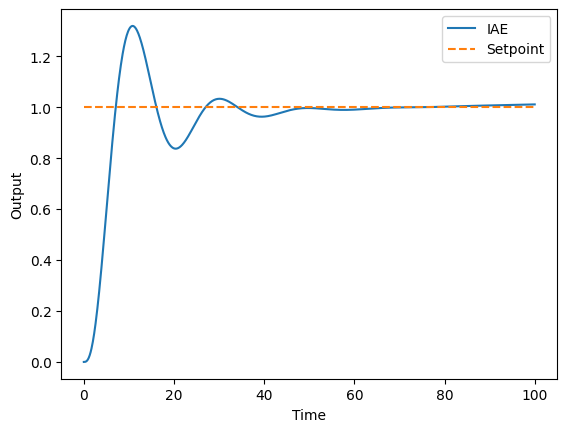

In [3]:
# Import modules
import control
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Define system transfer function
g = control.tf([6], [48, 52, 14, 1])

# Define lambda for IMC tuning rule
lam = 10

# Define IAE function
def iae(params, sp, dist):
    # Unpack controller parameters
    kp, ki = params
    # Define controller transfer function
    c = control.tf([kp, ki], [1, 0])
    # Define closed-loop transfer function
    cl = control.feedback(c*g, 1)
    # Define time vector
    t = np.linspace(0, 100, 1000, endpoint=False)
    # Simulate step response with setpoint and disturbance
    t_resp, y = control.step_response(cl*(sp + dist), t)
    # Calculate IAE
    iae = np.trapz(np.abs(sp - y), t_resp)
    return iae

# Define setpoint and disturbance values
sp = 1
dist = 0.2

# Find optimal PI controller parameters using IAE criterion
res = opt.minimize(iae, [1, 1], args=(sp, dist))
kp_iae, ki_iae = res.x

# Calculate PI controller parameters using IMC tuning rule
kp_imc = (2 - lam*g.dcgain())/(lam*g.dcgain())
ki_imc = kp_imc/lam

# Define PI controller transfer functions
c_iae = control.tf([kp_iae, ki_iae], [1, 0])
c_imc = control.tf([kp_imc, ki_imc], [1, 0])

# Define closed-loop transfer functions
cl_iae = control.feedback(c_iae*g, 1)
cl_imc = control.feedback(c_imc*g, 1)

# Simulate step responses
t = np.linspace(0, 100, 1000)
t_resp, y_iae = control.step_response(cl_iae*(sp + dist), t)
t_resp, y_imc = control.step_response(cl_imc*(sp + dist), t)
#print(y_iae)

# Plot step responses
plt.plot(t_resp, y_iae, label='IAE')
#plt.plot(t_resp, y_imc, label='IMC')
plt.plot(t_resp, sp*np.ones_like(t_resp), '--', label='Setpoint')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.show()


#Fitting the second order model

Kp = 6.038
tau = 10.929
theta = 3.730
R = 0.997
R^2 = 0.994


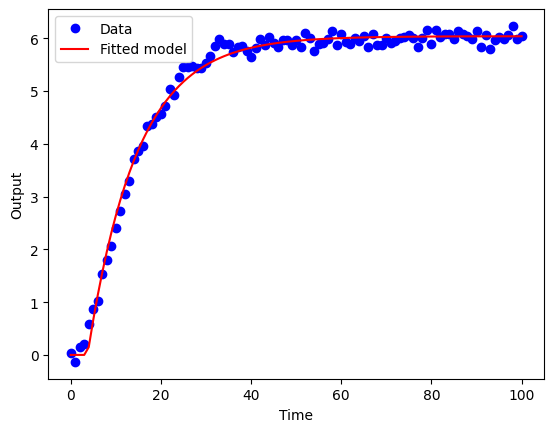

In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define system transfer function
g = control.tf([6], [48, 52, 14, 1])

# Generate some data from the system
t = np.linspace(0, 100, 101)
u = np.ones_like(t)
y = control.forced_response(g, t, u)[1]

# Add some noise to the data
y = y + np.random.normal(0, 0.1, len(y))

# Define FOPDT model function
def fopdt_model(t, Kp, tau, theta):
    y = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < theta:
            y[i] = 0
        else:
            y[i] = Kp * (1 - np.exp(-(t[i] - theta) / tau))
    return y

# Define objective function for optimization
def objective(p):
    Kp, tau, theta = p
    y_pred = fopdt_model(t, Kp, tau, theta)
    return np.sum((y - y_pred) ** 2)

# Set initial guesses for the parameters
p0 = [5, 5, 1]

# Perform optimization
result = minimize(objective, p0)

# Print the optimal parameters
Kp, tau, theta = result.x
print(f'Kp = {Kp:.3f}\ntau = {tau:.3f}\ntheta = {theta:.3f}')

# Calculate R and R^2
y_pred = fopdt_model(t, *result.x)
R = np.corrcoef(y, y_pred)[0,1]
R2 = R**2

# Print R and R^2
print(f'R = {R:.3f}\nR^2 = {R2:.3f}')

# Plot the data and the fitted model
plt.plot(t, y, 'bo', label='Data')
plt.plot(t, y_pred, 'r-', label='Fitted model')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.show()

PI Comparison